# Assignment: Principal Component Analysis (PCA) and K-Means Clustering

The goal of this notebook is to implement and explore data using unsupervised 
learning. Specifically, you will implement principal component analysis and the 
KMeans algorithm to perform both dimensionality reduction and unsupervised clustering
of some data to try and find hidden structure in high-dimensional data and
estimate the number of clusters in this dataset. 

## Submission Guidelines

### 1. Complete the Jupyter Notebook
- Fill in the missing code sections marked with `TODO`.  
- Ensure all required implementations are completed correctly.  

### 2. Include All Outputs
- Run all cells in the notebook before submission.  
- Ensure that outputs (e.g., printed results, tables, confusion matrices) are visible.  
- Submissions with missing outputs will be penalized.  

### 3. Submit Only the Notebook File (`.ipynb`)
- **Do NOT** submit the dataset file or any saved plots.  
- Your submission should consist of a single `.ipynb` file.  

### 4. Code Clarity & Documentation
- Use appropriate comments to explain modifications or additions to the code (that is not part of open-ended questions)

⚠️ **Failure to adhere to these guidelines may result in deductions.**

### Rubric (Total = 55 points):
1. **PCA**:  
   - Centering data.  **[3 points]**
   - Computing eigen decomposition.  **[5 points]**
   - Selecting optimal number of dimensions **[5 points]**
   - Projecting new data **[5 points]**


2. **K-means**:  
   - fit function.  **[10 points]**
   - predict function.  **[5 points]**
   - Initializing K-means.  **[2 points]**
   - Analysis of K-means with different K **[5 points]**

3. **Identifying the clusters**:  **[5 points]**
4. **Finding K**:  **[10 points]**


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [31]:
#
# TODO
#
# Load in the data using numpy

X =np.load("data.npy") 

X.shape 

(7708, 784)

In [32]:
print(X[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
#
# TODO
#
# Mean center the data, and divide by the standard deviation (in a numerically stable 
# way) as a general preprocessing step for some of the steps we are going to do.

mean_X = np.mean(X, axis=0)  # Computing mean for each feature- features are across the column
std_X = np.std(X, axis=0)  # Computing standard deviation for each feature

# Avoid division by zero
std_X[std_X == 0] = 1  

X = (X - mean_X) / std_X 
X =  np.nan_to_num(X)

print(X[:20]) 
 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# **Principal Component Analysis (PCA)**

## **Introduction**
Principal Component Analysis (PCA) is a dimensionality reduction technique that projects high-dimensional data into a lower-dimensional space while preserving the most significant variance. It is widely used for feature extraction, noise reduction, and visualization.

Given a dataset $X$ of shape $(n, d)$:
- The goal is to **reduce dimensionality** while retaining at least **95% variance** (default setting).
- If the number of principal components (`num_dim`) is **not specified**, it is determined automatically based on the percentage of variance retained.

---

## **Algorithm Steps**
### **1. Centering the Data**
To ensure that PCA finds the most significant directions of variance, the first step is to center the data by subtracting the mean:

$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

where $\mu$ is the **mean vector** of shape $(1, d)$, and $x_i$ represents individual data points.

The centered data matrix is:

$$
X_{\text{centered}} = X - \mu
$$

---

### **2. Computing Eigenvalues and Eigenvectors**
To determine the principal components, we compute the **covariance matrix**:

$$
\Sigma = \frac{1}{n} X_{\text{centered}}^T X_{\text{centered}}
$$

The **eigenvalues** and **eigenvectors** of $\Sigma$ are found by solving:

$$
\Sigma v = \lambda v
$$

where:
- $\lambda$ represents the **eigenvalues**.
- $v$ represents the **eigenvectors**, which define the **principal components**.

In implementation, we use `numpy.eigh()` instead of `numpy.eig()` for numerical stability.

---

### **3. Selecting the Optimal Number of Dimensions**
If `num_dim` is not specified, the number of components is determined based on the percentage of variance to retain:

$$
\frac{\sum_{i=1}^{k} \lambda_i}{\sum_{i=1}^{d} \lambda_i} \geq \text{percent}
$$

where:
- $\lambda_i$ are the eigenvalues **sorted in descending order**.
- $k$ is the number of dimensions needed to retain the required variance.

---

### **4. Projection onto Principal Components**
Once the **top-k eigenvectors** (principal components) are selected, the data is projected into a lower-dimensional space:

$$
X_{\text{PCA}} = X_{\text{centered}} W
$$

where $W$ is the **projection matrix** containing the **top-k eigenvectors**.

---

**NOTE:** You may have noticed that the definition of the covariance matrix and the projection operation are a bit different from the lecture. This difference is due to the fact that the dataset $X$ has features in its columns and samples in its rows. In class, we considered $X$ with features in its rows and samples in its columns. Be congnizant of this difference when you write code.

In [34]:
class PCA:
    def __init__(self, percent = 0.95, num_dim = None):
        """
        Args:
            percent (float): The percentage of variance.
            num_dim (int): The number of dimensions to keep, if None, we will 
                refer to the percentage of variance to determine.
                
        """
        self.percent = percent  
        self.num_dim = num_dim  
        self.mean = None  # Store the means of training data for normalizing purpose
        self.W = None  # Placeholder of projection matrix

    def fit(self, X):
        # Normalize the data to make it centered at zero
        self.mean = X.mean(axis = 0).reshape(1, -1)
        X = centerData(X, self.mean)

        # Find the projection matrix that maximize the variance (Hint: for eigen 
        # computation, use numpy.eigh instead of numpy.eig)
        eig_val, eig_vec = computeE(X)

        # If we do not specify the num_dim, we will compute the num_dim based on the 
        # percentage of cov
        if self.num_dim is None:
            # Select the reduced dimension that keep >90% of the variance
            self.num_dim = computeDim(eig_val, self.percent)

        # Determine the projection matrix and store it as class attribute
        self.W = eig_vec[:, :self.num_dim]

        # Project the high-dimensional data to low-dimensional one
        X_pca = project(X, self.W)

        return X_pca, self.num_dim

    def transform(self, X):
        X = centerData(X, self.mean)
        X_pca = project(X, self.W)
        return X_pca
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def params(self):
        return self.W, self.mean, self.num_dim


## Fill in the helper functions below

In [35]:
def centerData(X, mean):
    """
    Center the data based on the computed mean.
    
    Args:
        X (np.ndarray): The data of shape (n, d).
        mean (np.ndarray): The precomputed mean of shape (1, d).
        
    Returns:
        np.ndarray: The centered array of shape (n, d).
        
    """
    #centered_X = np.zeros_like(X)  # Placeholder, can be ignored or removed if needed.

    # 
    # TODO
    # Fill in your code below Question- do we use mean_X which we computed before in step 1?
    centered_X = X - mean
    return centered_X


def computeE(centered_X):
    """
    Compute the eigenvectors and eigenvalues.
    
    Args:
      centered_X: data, (n,d)
      
    Returns:
        np.ndarray: The eigenvectors of shape (d, p).
        np.ndarray: The eigenvalues of shape (p,) where p is the number of eigenvectors.
      
    """
    # Placeholders, can be ignored or removed if needed
    #eig_val = 0
    #eig_vec = np.zeros([centered_X.shape[1]])

    #
    # TODO
    #
    # (1) Get the covariance matrix
    cov_matrix = np.dot(centered_X.T, centered_X)/centered_X.shape[0]  
    # (2) Eigen-decomposition of cov (hint: you can use np.linalg.eigh()). Note that the output vals and 
    # corresponding vectors should be in ascending order by default, and the shape of vectors are (d, p).
    eig_val, eig_vec = np.linalg.eigh(cov_matrix)
    # (3) Reverse the order of eig_val and eig_vec to now make it in descending order
    eig_val = eig_val[::-1]
    eig_vec = eig_vec[:,::-1]


    return eig_val, eig_vec

#here i specified percent to be 0.95 is this needed? 
def computeDim(eig_val, percent= 0.95):
    """
    Compute number of dimensions
    
    Args:
      eig_val (np.ndarray): The eigenvalues of shape (p,).
      percent (float): The percentage of variance to keep.
      
    Returns:
        int: The number of dimensions to keep.
        
    """
    #num_dim = 0 # Placeholder, can be ignored or removed if needed.

    #
    # TODO
    total_variance = np.sum(eig_val)
    cum_variance = 0  # initializing the cumulative variance to 0 at first
    num_dim = 0     #initializing the number of compoenents to be 0 at first
    # Iterate to add eigenvalues, until you reach the percentage to keep.
    for val in range(len(eig_val)):
        cum_variance += eig_val[val]
        num_dim +=1
        if cum_variance / total_variance >= percent:
            break
    # Ex: If eig_val = [0.1, 0.1, 0.3, 0.1, 0.1, 0.3] and to keep percent > 0.5, num_dim = 4, 
    # Because (0.1+0.1+0.3) / sum(eig_val) = 0.5 is no bigger than 0.5, while 
    # (0.1+0.1+0.3+0.1) / sum(eig_val) > 0.5

    return num_dim


def project(X, w):
    """
    Project the data to lower dimensions
    
    Args:
        X (np.ndarrya): Centered data (n, d).
        W (np.ndarray): Projection matrix (d, p).
        
    Returns:
        np.ndarray: Projected data (n, p).
        
    """
    #X_pca = np.zeros([X.shape[0], w.shape[1]]) # Placeholder, can be ignored or removed if needed.

    #
    # TODO
    
    # Fill in your code
    X_pca = np.dot(X, w)

    return X_pca


Now, with PCA implemented, let's reduce the dimensionality of our dataset using PCA for visualization purposes.


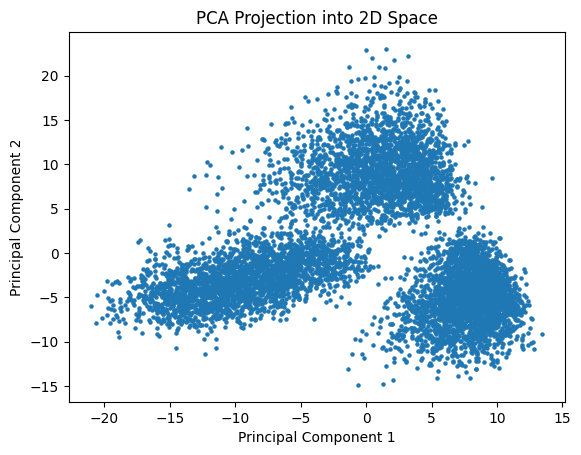

In [36]:
# 
# TODO
#
# Initialize the PCA class to perform dimensionality reduction down 
# into 2 dimensions (for visualization purposes).
pca = PCA(num_dim=2)

# Fit the model, and project it into the lower dimensional space 
X_reduced = pca.fit_transform(X)

# Plot the resulting lower dimensional data
plt.scatter(x = X_reduced[:, 0], y = X_reduced[:, 1], s = 5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection into 2D Space")
plt.show()

### Question 1: How many clusters do you see?

I see three clusters in the PCA.

# **K-Means Clustering Algorithm**

## **Introduction**
K-Means is an unsupervised clustering algorithm that partitions a dataset into $k$ clusters by minimizing the variance within each cluster. This implementation follows the standard **Expectation-Maximization (E-M) framework**, where:

1. **E-Step**: Assigns each data point to the nearest cluster.
2. **M-Step**: Updates cluster centers based on the mean of assigned points.
3. **Convergence**: The process repeats until cluster assignments remain unchanged.

---

## **Algorithm Steps**
### **1. Initialization**
- Given a dataset $X$ of shape $(n, d)$ where $n$ is the number of samples and $d$ is the number of features.
- Select $k$ initial cluster centers **randomly** or from predefined indices.

Mathematically, let $C = \{ c_1, c_2, ..., c_k \}$ be the set of cluster centers.

### **2. Expectation Step (E-Step)**
For each data point $x_i$, compute its distance to all cluster centers and assign it to the closest one:

$$
c(x_i) = \arg\min_{j} \| x_i - c_j \|_2
$$

where $\| x_i - c_j \|_2$ represents the **Euclidean distance** between point $x_i$ and cluster $c_j$.

### **3. Maximization Step (M-Step)**
After assigning points to clusters, update each cluster center by computing the mean of all assigned points:

$$
c_j = \frac{1}{|S_j|} \sum_{x_i \in S_j} x_i
$$

where $S_j$ is the set of points assigned to cluster $j$, and $|S_j|$ is the number of points in the cluster.

### **4. Convergence Criteria**
Repeat the **E-step** and **M-step** until:

$$
\sum_{i=1}^{n} \mathbb{1}[c(x_i) = \text{previous\_assignment}(x_i)] = n
$$

i.e., the cluster assignments no longer change.


## Fill in the helper functions below.

fit: K-means algorithm including the E and M steps.

predict: assign clusters to data points based on current centers.

In [37]:
import random

class KMeans:
    def __init__(self, k_clusters = 2):
        self.k_clusters = k_clusters
        
    def fit(self, X, max_iter = 1_000):
        #
        # TODO
        #
        # Initialize the centers by randomly selecting `k_clusters` samples from X.
        random_index = random.sample(range(len(X)), self.k_clusters)
        self.centers = X[random_index]    #randomly selecting initial cluster center

        old_cluster = None # Placeholder for the clusters from the previous step
        converged = False
        for _ in range(max_iter):
            new_cluster = self.predict(X)

            #
            # TODO
            # 
            # What is the criterion for convergence? Put it in the parentheses.
            if np.array_equal(new_cluster, old_cluster):
                converged = True
                break

            old_cluster = new_cluster
            
            for i in range(self.k_clusters):
                # 
                # TODO
                #
                # For each cluster (i), perform the M-STEP update here. Hint: This
                # will require updating `self.centers`.
                points_in_cluster = X[new_cluster == i]   
                if len(points_in_cluster) > 0:  # Avoid empty cluster issue
                    self.centers[i] = np.mean(points_in_cluster, axis=0)
        return self.centers

    def predict(self, X):
        """Predict the labels of test samples based on their clustering results"""
        prediction = np.zeros([len(X),], dtype = int)  # Placeholder, can be done without or removed if wanted

        # iterate through the test samples
        for i in range(len(X)):
        # TODO:
            
            # (1) Find the cluster of each sample
            # (2) Get the label of the cluster as predicted label for that data
            distances = np.linalg.norm(X[i] - self.centers, axis=1)
            prediction[i] = np.argmin(distances)

        return prediction


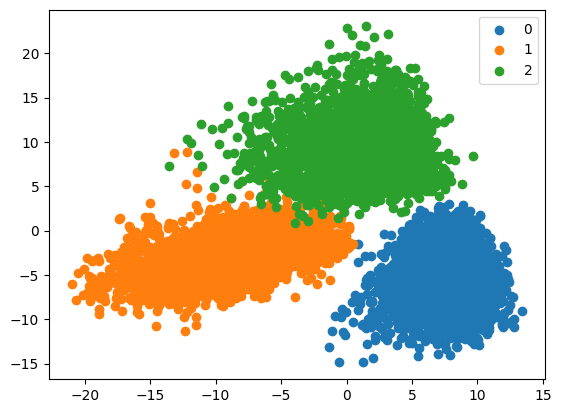

In [38]:
#
# TODO
#
# Initialize KMeans with the number of clusters you think is appropriate based on the previous PCA analysis
kmeans = KMeans(k_clusters=3)

kmeans.fit(X)
labels = kmeans.predict(X)

# Plot the previously reduced data
for label in np.unique(labels):
    plt.scatter(*X_reduced[labels == label].T, label = str(label))
    
plt.legend()
plt.show()

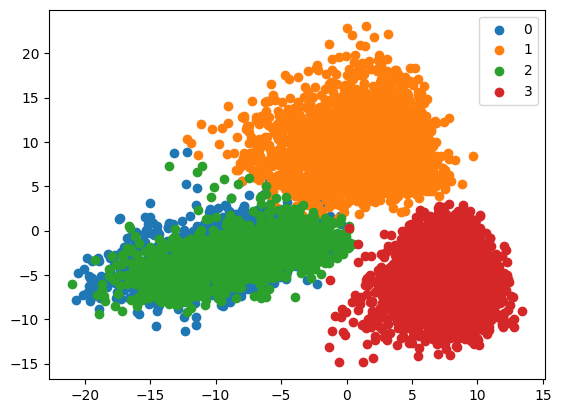

In [39]:
# Initializing KMeans with four cluster to see how the cluster center varies for the question 2. 
kmean_4 = KMeans(k_clusters=4)

kmean_4.fit(X)
labels_4 = kmean_4.predict(X)

# Plot the previously reduced data
for label in np.unique(labels_4):
    plt.scatter(*X_reduced[labels_4 == label].T, label = str(label))
    
plt.legend()
plt.show()

### Question 2: Rerun the KMeans code above a couple of times (and possibly with a different number of clusters). Do you get the same results everytime? Are the cluster assignments good in all runs? Explain your findings.

[Answer goes here]
#No each time I rerun this clustering , I get different clusters with different colors and different shape. The result vary due to the random initialization of cluster centers. We are choosing the cluster center using random.sample. So the cluster assignment change between every runs. K means is sensitive to initialization as it try to optimize around the initial cluster center, meaning it converge on local optimim.
#When I rerun using the differnet number of cluster other than 3, the k means tried to divide the cluster into finer groups. However, with k=4, I see much overlap between cluster in green and red.  The rest of the pther two cluster appear compact and distincet with very few common data points. Based on this k=4 seem to give overclustering as the new clusters share many common datapoints with one of the other cluster. And because of the random cluster initialization, the cluster assignent keep changing.  

### Question 3: Now that we know there are a certain number of clusters, can you inspect the data in each cluster to identify what these clusters represent?  

**HINT:** Each sample in the dataset is actually a square image flattened into a 1-dimensional vector. Consider plotting the samples as images.

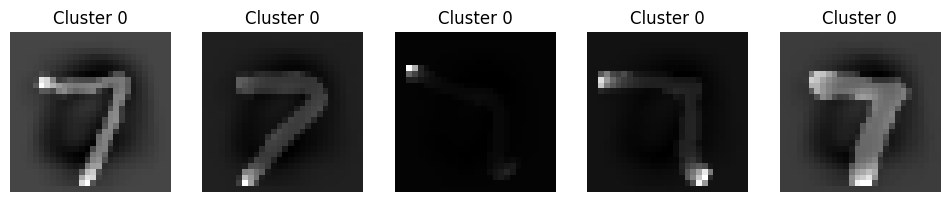

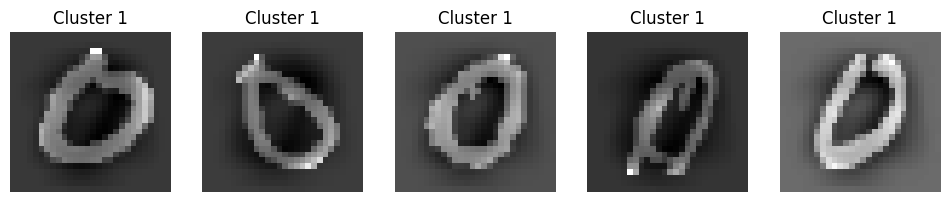

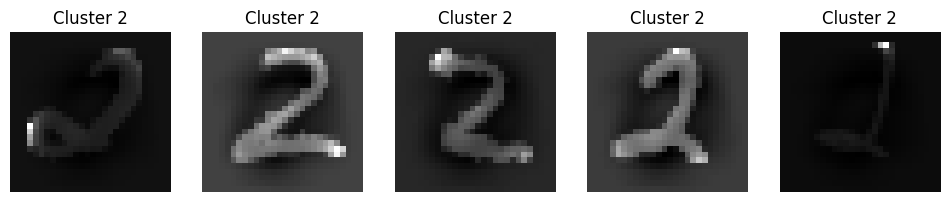

In [42]:
# Your code goes here
import matplotlib.pyplot as plt

def plot_sample_images(X, labels, cluster_num, num_samples=5):
    # Get indices of samples in the specified cluster
    cluster_indices = np.where(labels == cluster_num)[0]

    # Select a random subset of images from the cluster
    selected_indices = np.random.choice(cluster_indices, size=min(num_samples, len(cluster_indices)), replace=False)

    # Set up the plot grid
    fig, axes = plt.subplots(1, len(selected_indices), figsize=(12, 4))

    for i, idx in enumerate(selected_indices):
        # Reshape the 1D vector back to 28x28 image
        image = X[idx].reshape(28, 28)

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"Cluster {cluster_num}")

    plt.show()

unique_clusters = np.unique(labels)

# Plot sample images from each cluster
for cluster in unique_clusters:
    plot_sample_images(X, labels, cluster, num_samples=5)


[Answer goes here]
based on the plotted image I can see that the images in cluster 0 resembles the digit 7. These 7 are with differnt styles may be because of different writing style and some of the images are also not that clear. Similarly, the images in cluster 1 resembles the digit 0 with different styles. Finally, the images in cluster 2 resembles the digit 2. 

### Open Ended Question: Finding K 

Assume for a second that you don't know how many clusters (`K`) there are in this dataset (we know it's pretty obvious after applying PCA). In this case, you would have very high-dimensional data with maybe a bit less differentiation between the classes and PCA. Your goal is to now find the optimal value of `K` just from the KMeans results, and without using PCA.

In practice, there is rarely as good differentiation as you are getting in this dataset. For example, we had to process it to remove some of the samples to increase the differentiation to make it easier for you all. See the image below for what the PCA looked like applied on this same dataset before this slight processing. 

<img src="./before.png" width="50%">

In this case, it might not be obvious looking at the image on the right that there are 3 clusters. Real data is messy.

**Hint**: Consider using the K-means distortion measure ($J$) and the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)).

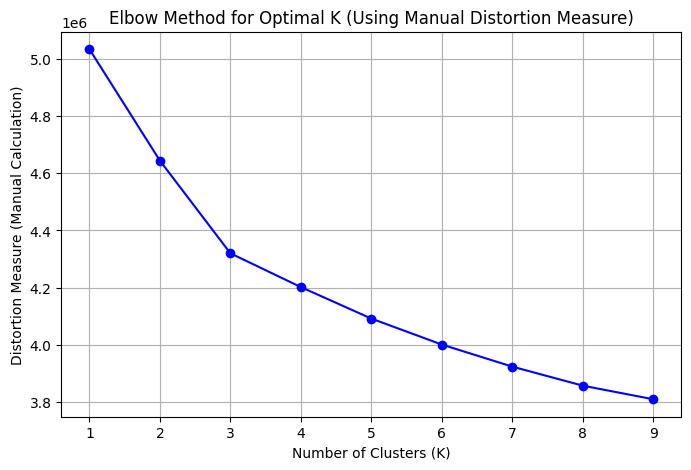

In [44]:
# You code should probably iterate over some number of clusters, then 
    # fit a KMeans model using `k`, and then compute some metric on top of
    # this to score the fit. This for loop can be removed if you want.
    # Define the range of K values explicitly
# Optimized function to compute distortion using vectorized operations
from sklearn.cluster import KMeans
def compute_distortion_optimized(X, labels, centers):
    # Compute squared Euclidean distance between each point and its assigned cluster center
    distances = np.linalg.norm(X - centers[labels], axis=1) ** 2
    return np.sum(distances)

# Define K values explicitly using np.arange()
k_values = np.arange(1, 10)  
distortion_values = []  # Store manually computed distortion measures

# Compute K-Means for different K values and store distortion measure
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=32, n_init=10, max_iter=300)  
    kmeans.fit(X)  # Fit K-Means model on full dataset
    
    # Compute distortion manually using optimized function
    distortion = compute_distortion_optimized(X, kmeans.labels_, kmeans.cluster_centers_)
    distortion_values.append(distortion)

# Plot the Elbow Curve using manually computed distortion measures
plt.figure(figsize=(8, 5))
plt.plot(k_values, distortion_values, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Distortion Measure (Manual Calculation)")
plt.title("Elbow Method for Optimal K (Using Manual Distortion Measure)")
plt.xticks(k_values)
plt.grid()
plt.show()


[Writeup for your answer goes here]
#Based on the result of distortion measure from the elbow plot, the optimal K would be 3. At k=3, we can see the elbow formation. The rate of decrease in distortion untill k=3 is very rapid/sharp. However after k=3, the distortion measure decreases slowly forming elbow in the plot. SO, i think the optimal value of k is 3. 
